# Decision Trees

This notebook implements **decision trees**, a non-parametric supervised learning method that works for both regression and classification tasks. It is a tree-like model of decisions, following a path from the root (node at the top of the tree, acting as the input node for feature vectors in the model) to the leaf (final node where the prediction is made).

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

# Import a nice function for plotting decision boundaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Import functions from scikit-learn to help with training/testing endeavors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# Import functions to make decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text

### The Data

The model will be trained using the [Hawks](https://r-data.pmagunia.com/dataset/r-dataset-package-stat2data-hawks) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


### The Task

I will implement the decision tree for classification tasks. Specifically, I will be continuing with classifying hawk species based on their wing and tail length. As a refresher, below are visualizations of the training and testing set in this aspect. It is clear that we we can formulate boundaries using decision trees to classify a given hawk.

In [3]:
# Data preparation step
X = hawks[["Wing", "Tail"]].to_numpy()
y = hawks["Species"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

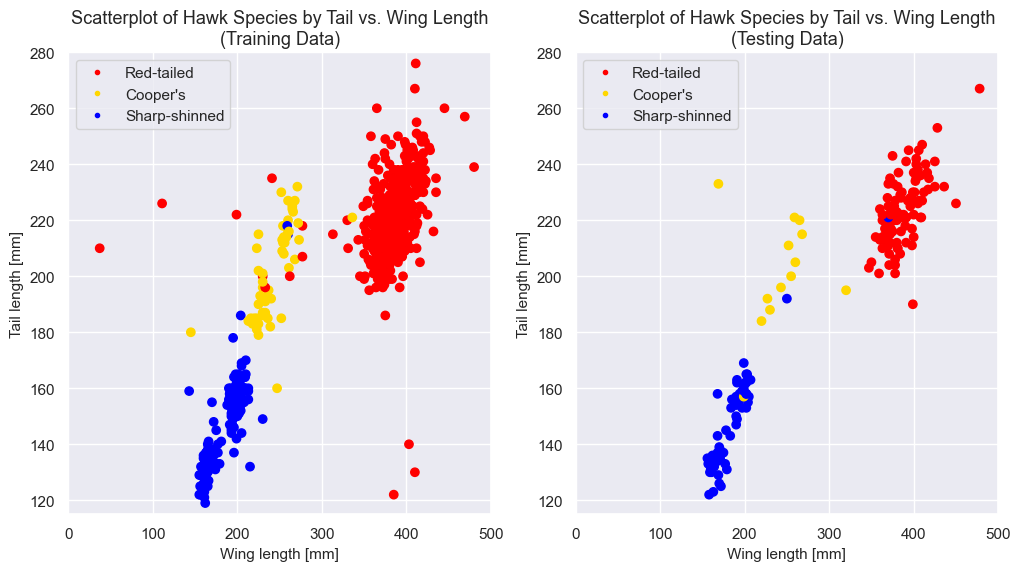

In [4]:
# For color coding points
species_colors = {"RT": "red", "CH": "gold", "SS": "blue"}

# For a custom legend
species_names = {"RT": "Red-tailed", "CH": "Cooper's", "SS": "Sharp-shinned"}
custom_legend = [Line2D([], [], marker='.', color='red', linestyle='None'),
                 Line2D([], [], marker='.', color='gold', linestyle='None'),
                 Line2D([], [], marker='.', color='blue', linestyle='None')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.set_xlim((0, 500))
ax1.set_ylim((115, 280))
ax1.scatter(X_train[:, 0], X_train[:, 1], color = [species_colors[y] for y in y_train])
ax1.set_xlabel("Wing length [mm]", fontsize = 11)
ax1.set_ylabel("Tail length [mm]", fontsize = 11)
ax1.set_title("Scatterplot of Hawk Species by Tail vs. Wing Length\n(Training Data)", fontsize = 13)
ax1.legend(fontsize = 11, loc = "upper left", handles = custom_legend, labels = species_names.values())

# Plot the testing set
ax2.set_xlim((0, 500))
ax2.set_ylim((115, 280))
ax2.scatter(X_test[:, 0], X_test[:, 1], color = [species_colors[y] for y in y_test])
ax2.set_xlabel("Wing length [mm]", fontsize = 11)
ax2.set_ylabel("Tail length [mm]", fontsize = 11)
ax2.set_title("Scatterplot of Hawk Species by Tail vs. Wing Length\n(Testing Data)", fontsize = 13)
ax2.legend(fontsize = 11, loc = "upper left", handles = custom_legend, labels = species_names.values())
plt.show()

### Training the model

The scikit-learn library allows for implementation of the decision tree for classification tasks. Below, a model is fit using the two predictors, and a `max_depth` of 3 for starters.

In [5]:
decision_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
decision_tree.fit(X_train, y_train)

tree_rules = export_text(decision_tree, feature_names = ["Wing length", "Tail length"])
print(tree_rules, "\n")

|--- Wing length <= 275.00
|   |--- Tail length <= 178.50
|   |   |--- Wing length <= 238.50
|   |   |   |--- class: SS
|   |   |--- Wing length >  238.50
|   |   |   |--- class: CH
|   |--- Tail length >  178.50
|   |   |--- Wing length <= 208.50
|   |   |   |--- class: RT
|   |   |--- Wing length >  208.50
|   |   |   |--- class: CH
|--- Wing length >  275.00
|   |--- Wing length <= 339.50
|   |   |--- Wing length <= 333.50
|   |   |   |--- class: RT
|   |   |--- Wing length >  333.50
|   |   |   |--- class: CH
|   |--- Wing length >  339.50
|   |   |--- Wing length <= 377.50
|   |   |   |--- class: RT
|   |   |--- Wing length >  377.50
|   |   |   |--- class: RT
 



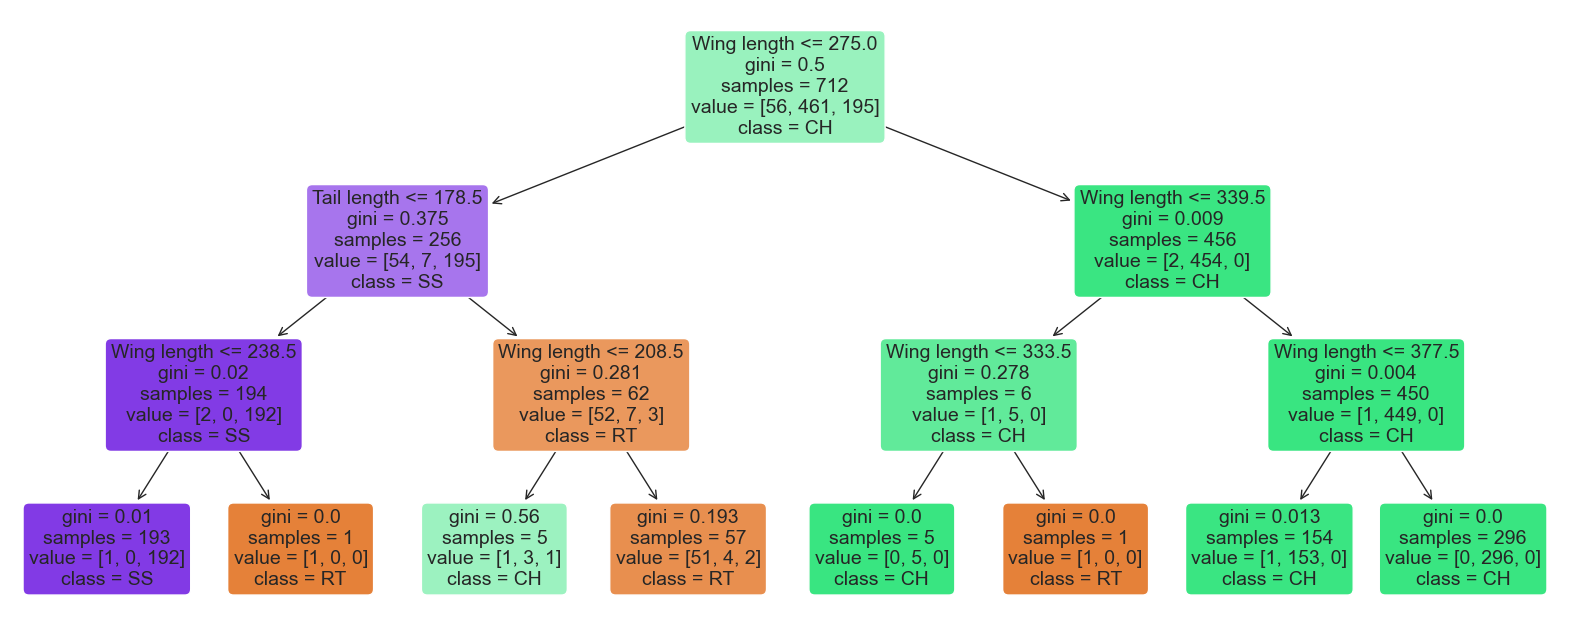

In [6]:
plt.figure(figsize=(20, 8))
a = plot_tree(decision_tree, feature_names = ["Wing length", "Tail length"],
              class_names = ["RT", "CH", "SS"],
              rounded = True, filled = True, fontsize=14)
plt.show()

The leaves of the tree suggest some overfitting may be at play. Notice that there are pairs of leaves where one of the leaves have a low sample count of a class/species. Examination of the decision regions plot confirms this observations.

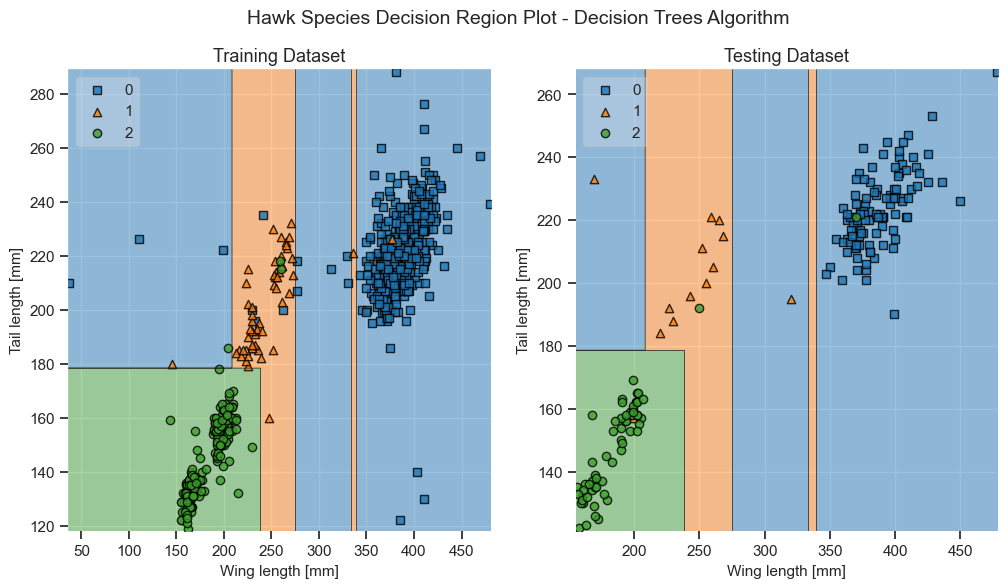

In [7]:
# plot_decision_regions function needs a numerical output, so make a new instance of the model
# using the same random_state (and same training data)
species_nums = {"RT" : 0, "CH" : 1, "SS" : 2}
y_train2 = np.array(list(map(lambda i : species_nums[i], y_train))) # line below accomplishes the same thing
y_test2 = np.array([0 if label == "RT" else 1 if label == "CH" else 2 for label in y_test])
decision_tree2 = DecisionTreeClassifier(max_depth=3, random_state=42)
decision_tree2.fit(X_train, y_train2)

# Plot the training and testing observations with decision regions overlaid
fig, axes = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle("Hawk Species Decision Region Plot - Decision Trees Algorithm", fontsize=14)
fig = plot_decision_regions(X_train, y_train2, clf = decision_tree2, ax = axes[0], legend = 2)
axes[0].set_title("Training Dataset", fontsize = 13)
axes[0].set_xlabel("Wing length [mm]", fontsize = 11)
axes[0].set_ylabel("Tail length [mm]", fontsize = 11)

fig = plot_decision_regions(X_test, y_test2, clf = decision_tree2, ax = axes[1], legend = 2)
axes[1].set_title("Testing Dataset", fontsize = 13)
axes[1].set_xlabel("Wing length [mm]", fontsize = 11)
axes[1].set_ylabel("Tail length [mm]", fontsize = 11)
plt.show()

* 0 = RT (Red-tailed)
* 1 = CH (Cooper's)
* 2 = SS (Sharp-Shinned)

In the above plot, the thin orange bar for the singular Cooper's hawk is a clear instance of overfitting. This is an "anamoly" observation, most of the other data in the region is the red-tailed hawk. 

On the other hand, some sharp-shinned hawks in the midst of the Cooper's hawks are present in both the training and testing data, but the decision tree did not account for these, leading to misclassification in that region.


### Error Analysis

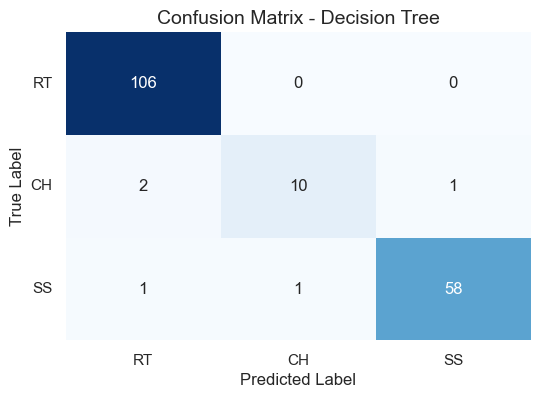

In [8]:
# Obtain predicted values on the testing data
y_pred = decision_tree.predict(X_test)

# Obtain confusion matrix and convert into dataframe
confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=["RT", "CH", "SS"])
matrix_df = pd.DataFrame(confusion_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
ax = plt.axes()
sns.heatmap(matrix_df, annot=True, cmap='Blues', cbar=False, fmt='g')
ax.set_title("Confusion Matrix - Decision Tree", fontsize = 14)
ax.set_xlabel("Predicted Label", fontsize = 12)
ax.set_xticklabels(["RT", "CH", "SS"])
ax.set_ylabel("True Label", fontsize = 12)
ax.set_yticklabels(["RT", "CH", "SS"], rotation=0)
plt.show()

In [9]:
#Checking model performance with classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          CH       0.91      0.77      0.83        13
          RT       0.97      1.00      0.99       106
          SS       0.98      0.97      0.97        60

    accuracy                           0.97       179
   macro avg       0.95      0.91      0.93       179
weighted avg       0.97      0.97      0.97       179



Most of the data is identified accurately!